In [1]:
import pandas as pd
from convolutional import ConvRegressor, ConvClassifier
from gridsearch_mlflow import run_gridsearch_with_mlflow
import mlflow
import mlflow.pytorch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import os
import torch
import matplotlib.pyplot as plt


df = pd.read_csv("data/datos_variables_seleccionadas.csv")


# K - Fold 

In [2]:

def plot_loss_curve(history, save_path):
    plt.figure(figsize=(8, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    if any(v is not None for v in history["val_loss"]):
        plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()

def run_kfold_cv_with_mlflow(model_class, df, target_col, experiment_name="kfold_regression", k=5, epochs=40, batch_size=32, save_dir="checkpoints_kfold/"):
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment(experiment_name)
    os.makedirs(save_dir, exist_ok=True)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\n Fold {fold+1}/{k}")
        with mlflow.start_run(run_name=f"fold_{fold+1}"):
            df_train = df.iloc[train_idx].drop(columns=['punt_matematicas', 'eco'], errors='ignore')
            df_val = df.iloc[val_idx].drop(columns=['punt_matematicas', 'eco'], errors='ignore')

            df_train[target_col] = df.iloc[train_idx][target_col]
            df_val[target_col] = df.iloc[val_idx][target_col]

            model = model_class()
            model.build_model(df_train.copy(), target_col)
            model.train(
                target_col=target_col,
                val_df=df_val.copy(),
                early_stopping=True,
                patience=3,
                epochs=epochs,
                batch_size=batch_size
            )

            y_true = df_val[target_col].values
            y_pred = model.predict(df_val.copy()).squeeze()

            mse = mean_squared_error(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            fold_metrics.append({'mse': mse, 'mae': mae, 'r2': r2})

            mlflow.log_param("fold", fold+1)
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("r2", r2)

            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            curve_path = os.path.join(save_dir, f"loss_curve_fold{fold+1}_{timestamp}.png")
            plot_loss_curve(model.history, curve_path)
            mlflow.log_artifact(curve_path)

    avg_mse = np.mean([m['mse'] for m in fold_metrics])
    avg_mae = np.mean([m['mae'] for m in fold_metrics])
    avg_r2 = np.mean([m['r2'] for m in fold_metrics])

    print(f"\n K-Fold Final Averages:\nMSE: {avg_mse:.4f}\nMAE: {avg_mae:.4f}\nR²: {avg_r2:.4f}")

    with mlflow.start_run(run_name="summary", nested=True):
        mlflow.log_metric("avg_mse", avg_mse)
        mlflow.log_metric("avg_mae", avg_mae)
        mlflow.log_metric("avg_r2", avg_r2)


In [ ]:
model_base = lambda: ConvRegressor(
    embedding_dim=4,
    conv_filters=[16, 32],
    dense_units=64
)

run_kfold_cv_with_mlflow(
    model_class=model_base,
    df=df,
    target_col='punt_matematicas',
    experiment_name='kfold_regression_baseline',
    k=5,
    epochs=10,
    batch_size=32
)



 Fold 1/5
 Iniciando entrenamiento en cuda con 452526 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 79.487022). Saving model...
 Época 1/10 | Train Loss: 132.1194 | Tiempo: 249.89s | Val Loss: 79.4870


Validation loss decreased (79.487022 --> 71.761314). Saving model...
 Época 2/10 | Train Loss: 99.8757 | Tiempo: 246.57s | Val Loss: 71.7613


Validation loss decreased (71.761314 --> 71.211624). Saving model...
 Época 3/10 | Train Loss: 88.9041 | Tiempo: 244.70s | Val Loss: 71.2116


Validation loss decreased (71.211624 --> 69.938194). Saving model...
 Época 4/10 | Train Loss: 85.1626 | Tiempo: 245.82s | Val Loss: 69.9382


Validation loss decreased (69.938194 --> 69.669823). Saving model...
 Época 5/10 | Train Loss: 82.4864 | Tiempo: 248.10s | Val Loss: 69.6698


Validation loss decreased (69.669823 --> 69.459015). Saving model...
 Época 6/10 | Train Loss: 80.4704 | Tiempo: 248.47s | Val Loss: 69.4590


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 78.6018 | Tiempo: 246.78s | Val Loss: 71.7533


EarlyStopping counter: 2 out of 3
 Época 8/10 | Train Loss: 77.0170 | Tiempo: 248.28s | Val Loss: 70.2199


EarlyStopping counter: 3 out of 3
 Época 9/10 | Train Loss: 75.8290 | Tiempo: 248.25s | Val Loss: 69.8571
Early stopping en época 9
🏃 View run fold_1 at: http://localhost:5000/#/experiments/466566127133930735/runs/8c5d10c1830849f3b64f07306edec49d
🧪 View experiment at: http://localhost:5000/#/experiments/466566127133930735

 Fold 2/5
 Iniciando entrenamiento en cuda con 452526 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 77.832832). Saving model...
 Época 1/10 | Train Loss: 136.5354 | Tiempo: 247.20s | Val Loss: 77.8328


Validation loss decreased (77.832832 --> 70.898994). Saving model...
 Época 2/10 | Train Loss: 101.7011 | Tiempo: 247.18s | Val Loss: 70.8990


Validation loss decreased (70.898994 --> 69.966751). Saving model...
 Época 3/10 | Train Loss: 91.1987 | Tiempo: 248.96s | Val Loss: 69.9668


Validation loss decreased (69.966751 --> 68.958366). Saving model...
 Época 4/10 | Train Loss: 87.2762 | Tiempo: 249.27s | Val Loss: 68.9584


Validation loss decreased (68.958366 --> 68.528969). Saving model...
 Época 5/10 | Train Loss: 83.7351 | Tiempo: 249.17s | Val Loss: 68.5290


EarlyStopping counter: 1 out of 3
 Época 6/10 | Train Loss: 81.0267 | Tiempo: 245.37s | Val Loss: 68.8949


EarlyStopping counter: 2 out of 3
 Época 7/10 | Train Loss: 78.9376 | Tiempo: 248.21s | Val Loss: 68.6954


Validation loss decreased (68.528969 --> 68.286469). Saving model...
 Época 8/10 | Train Loss: 77.3920 | Tiempo: 247.08s | Val Loss: 68.2865


EarlyStopping counter: 1 out of 3
 Época 9/10 | Train Loss: 75.9244 | Tiempo: 246.64s | Val Loss: 68.3432


EarlyStopping counter: 2 out of 3
 Época 10/10 | Train Loss: 74.8987 | Tiempo: 247.05s | Val Loss: 68.4124
🏃 View run fold_2 at: http://localhost:5000/#/experiments/466566127133930735/runs/03e0a7fa8e634e0dbbc36621531da098
🧪 View experiment at: http://localhost:5000/#/experiments/466566127133930735

 Fold 3/5
 Iniciando entrenamiento en cuda con 452526 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 79.977203). Saving model...
 Época 1/10 | Train Loss: 131.4407 | Tiempo: 239.02s | Val Loss: 79.9772


Validation loss decreased (79.977203 --> 70.588112). Saving model...
 Época 2/10 | Train Loss: 102.1415 | Tiempo: 238.20s | Val Loss: 70.5881


Validation loss decreased (70.588112 --> 69.595871). Saving model...
 Época 3/10 | Train Loss: 89.8583 | Tiempo: 236.95s | Val Loss: 69.5959


EarlyStopping counter: 1 out of 3
 Época 4/10 | Train Loss: 86.3939 | Tiempo: 238.59s | Val Loss: 69.7439


Validation loss decreased (69.595871 --> 69.195633). Saving model...
 Época 5/10 | Train Loss: 83.0505 | Tiempo: 240.59s | Val Loss: 69.1956


Validation loss decreased (69.195633 --> 69.067810). Saving model...
 Época 6/10 | Train Loss: 80.7708 | Tiempo: 240.16s | Val Loss: 69.0678


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 78.6788 | Tiempo: 241.22s | Val Loss: 69.2220


EarlyStopping counter: 2 out of 3
 Época 8/10 | Train Loss: 77.2219 | Tiempo: 240.56s | Val Loss: 69.2393


Validation loss decreased (69.067810 --> 69.056404). Saving model...
 Época 9/10 | Train Loss: 75.9236 | Tiempo: 241.36s | Val Loss: 69.0564


EarlyStopping counter: 1 out of 3
 Época 10/10 | Train Loss: 75.0441 | Tiempo: 242.14s | Val Loss: 69.0772
🏃 View run fold_3 at: http://localhost:5000/#/experiments/466566127133930735/runs/2bc219dd8d0a4b958012b387c1b11615
🧪 View experiment at: http://localhost:5000/#/experiments/466566127133930735

 Fold 4/5
[LabelEncoderWithUnknown] 1 valores no vistos transformados a '__unknown__'
 Iniciando entrenamiento en cuda con 452527 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 79.487350). Saving model...
 Época 1/10 | Train Loss: 132.9629 | Tiempo: 242.46s | Val Loss: 79.4874


Validation loss decreased (79.487350 --> 71.102394). Saving model...
 Época 2/10 | Train Loss: 95.6287 | Tiempo: 242.47s | Val Loss: 71.1024


Validation loss decreased (71.102394 --> 70.054901). Saving model...
 Época 3/10 | Train Loss: 87.6300 | Tiempo: 244.39s | Val Loss: 70.0549


Validation loss decreased (70.054901 --> 69.741066). Saving model...
 Época 4/10 | Train Loss: 84.5538 | Tiempo: 243.76s | Val Loss: 69.7411


EarlyStopping counter: 1 out of 3
 Época 5/10 | Train Loss: 82.2846 | Tiempo: 246.71s | Val Loss: 70.9772


Validation loss decreased (69.741066 --> 69.560066). Saving model...
 Época 6/10 | Train Loss: 80.3114 | Tiempo: 244.75s | Val Loss: 69.5601


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 78.6758 | Tiempo: 247.32s | Val Loss: 70.0856


Validation loss decreased (69.560066 --> 69.058441). Saving model...
 Época 8/10 | Train Loss: 77.2798 | Tiempo: 246.01s | Val Loss: 69.0584


EarlyStopping counter: 1 out of 3
 Época 9/10 | Train Loss: 76.1229 | Tiempo: 247.32s | Val Loss: 69.7936


EarlyStopping counter: 2 out of 3
 Época 10/10 | Train Loss: 74.9251 | Tiempo: 245.66s | Val Loss: 69.2337
[LabelEncoderWithUnknown] 1 valores no vistos transformados a '__unknown__'
🏃 View run fold_4 at: http://localhost:5000/#/experiments/466566127133930735/runs/9defd7b64b7e484f9e1213f692309f06
🧪 View experiment at: http://localhost:5000/#/experiments/466566127133930735

 Fold 5/5
[LabelEncoderWithUnknown] 1 valores no vistos transformados a '__unknown__'
 Iniciando entrenamiento en cuda con 452527 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 82.889610). Saving model...
 Época 1/10 | Train Loss: 132.1757 | Tiempo: 242.41s | Val Loss: 82.8896


Validation loss decreased (82.889610 --> 71.614960). Saving model...
 Época 2/10 | Train Loss: 98.7655 | Tiempo: 242.23s | Val Loss: 71.6150


Validation loss decreased (71.614960 --> 69.467476). Saving model...
 Época 3/10 | Train Loss: 89.1179 | Tiempo: 243.05s | Val Loss: 69.4675


Validation loss decreased (69.467476 --> 68.961761). Saving model...
 Época 4/10 | Train Loss: 85.4647 | Tiempo: 244.32s | Val Loss: 68.9618


EarlyStopping counter: 1 out of 3
 Época 5/10 | Train Loss: 82.9771 | Tiempo: 243.23s | Val Loss: 68.9739


Validation loss decreased (68.961761 --> 68.552925). Saving model...
 Época 6/10 | Train Loss: 80.5278 | Tiempo: 243.87s | Val Loss: 68.5529


Validation loss decreased (68.552925 --> 68.521873). Saving model...
 Época 7/10 | Train Loss: 78.6394 | Tiempo: 243.88s | Val Loss: 68.5219


EarlyStopping counter: 1 out of 3
 Época 8/10 | Train Loss: 77.3048 | Tiempo: 242.85s | Val Loss: 68.8466


EarlyStopping counter: 2 out of 3
 Época 9/10 | Train Loss: 76.1064 | Tiempo: 240.78s | Val Loss: 68.8755


EarlyStopping counter: 3 out of 3
 Época 10/10 | Train Loss: 75.0120 | Tiempo: 257.36s | Val Loss: 68.7679
Early stopping en época 10
[LabelEncoderWithUnknown] 1 valores no vistos transformados a '__unknown__'
🏃 View run fold_5 at: http://localhost:5000/#/experiments/466566127133930735/runs/fd3e3256c1fc45ef974cfc72a4195521
🧪 View experiment at: http://localhost:5000/#/experiments/466566127133930735

 K-Fold Final Averages:
MSE: 68.9408
MAE: 6.4343
R²: 0.3193
🏃 View run summary at: http://localhost:5000/#/experiments/466566127133930735/runs/a7139c984600448aac04f0aae6180d92
🧪 View experiment at: http://localhost:5000/#/experiments/466566127133930735


: 

# Grid search

In [2]:
param_grid_reg = {
    'embedding_dim': [4, 8],
    'conv_filters': [[16, 32], [32, 64]],
    'dense_units': [64],
    'epochs': [10, 25],
    'batch_size': [32, 16],
    'patience': [3]
}

best_reg_model = run_gridsearch_with_mlflow(
    df=df,
    target_col='punt_matematicas',
    param_grid=param_grid_reg,
    task_type='regression',
    experiment_name='grid_conv_regression',
    save_dir='checkpoints/',
    return_best_model=True
)


 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 75.420341). Saving model...
 Época 1/10 | Train Loss: 138.8946 | Tiempo: 189.99s | Val Loss: 75.4203


Validation loss decreased (75.420341 --> 70.999382). Saving model...
 Época 2/10 | Train Loss: 100.5192 | Tiempo: 205.11s | Val Loss: 70.9994


EarlyStopping counter: 1 out of 3
 Época 3/10 | Train Loss: 90.6817 | Tiempo: 184.17s | Val Loss: 71.9167


Validation loss decreased (70.999382 --> 70.363274). Saving model...
 Época 4/10 | Train Loss: 87.3563 | Tiempo: 188.20s | Val Loss: 70.3633


Validation loss decreased (70.363274 --> 69.446785). Saving model...
 Época 5/10 | Train Loss: 84.3436 | Tiempo: 218.73s | Val Loss: 69.4468


Validation loss decreased (69.446785 --> 69.307709). Saving model...
 Época 6/10 | Train Loss: 82.1837 | Tiempo: 221.92s | Val Loss: 69.3077


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 80.0741 | Tiempo: 207.12s | Val Loss: 69.7321


Validation loss decreased (69.307709 --> 69.279701). Saving model...
 Época 8/10 | Train Loss: 78.4756 | Tiempo: 222.40s | Val Loss: 69.2797


EarlyStopping counter: 1 out of 3
 Época 9/10 | Train Loss: 76.8369 | Tiempo: 201.18s | Val Loss: 69.4967


Validation loss decreased (69.279701 --> 69.210876). Saving model...
 Época 10/10 | Train Loss: 75.7687 | Tiempo: 209.73s | Val Loss: 69.2109


2025/05/21 11:25:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 11:25:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 11:25:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run agreeable-grouse-411 at: http://localhost:5000/#/experiments/294710831823527254/runs/18b9bf8e24a4402f9a8c60454201d5b2
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 71.718735). Saving model...
 Época 1/10 | Train Loss: 145.7896 | Tiempo: 388.98s | Val Loss: 71.7187


Validation loss decreased (71.718735 --> 70.620491). Saving model...
 Época 2/10 | Train Loss: 99.3257 | Tiempo: 413.60s | Val Loss: 70.6205


Validation loss decreased (70.620491 --> 70.141479). Saving model...
 Época 3/10 | Train Loss: 85.5305 | Tiempo: 382.68s | Val Loss: 70.1415


Validation loss decreased (70.141479 --> 69.982330). Saving model...
 Época 4/10 | Train Loss: 81.2871 | Tiempo: 384.12s | Val Loss: 69.9823


EarlyStopping counter: 1 out of 3
 Época 5/10 | Train Loss: 78.3277 | Tiempo: 371.66s | Val Loss: 70.1332


Validation loss decreased (69.982330 --> 69.375900). Saving model...
 Época 6/10 | Train Loss: 76.2964 | Tiempo: 377.69s | Val Loss: 69.3759


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 74.7351 | Tiempo: 371.50s | Val Loss: 69.6147


Validation loss decreased (69.375900 --> 69.259850). Saving model...
 Época 8/10 | Train Loss: 73.3888 | Tiempo: 366.68s | Val Loss: 69.2598


Validation loss decreased (69.259850 --> 69.039230). Saving model...
 Época 9/10 | Train Loss: 72.4996 | Tiempo: 368.15s | Val Loss: 69.0392


Validation loss decreased (69.039230 --> 68.805252). Saving model...
 Época 10/10 | Train Loss: 71.9038 | Tiempo: 371.85s | Val Loss: 68.8053


2025/05/21 12:29:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 12:30:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 12:30:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run languid-gull-849 at: http://localhost:5000/#/experiments/294710831823527254/runs/e3c3b37d7ccb4809927b5c815c11f044
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 88.864601). Saving model...
 Época 1/25 | Train Loss: 136.3041 | Tiempo: 186.88s | Val Loss: 88.8646


Validation loss decreased (88.864601 --> 70.502419). Saving model...
 Época 2/25 | Train Loss: 101.8711 | Tiempo: 189.27s | Val Loss: 70.5024


Validation loss decreased (70.502419 --> 70.200325). Saving model...
 Época 3/25 | Train Loss: 90.7547 | Tiempo: 185.11s | Val Loss: 70.2003


Validation loss decreased (70.200325 --> 70.103973). Saving model...
 Época 4/25 | Train Loss: 87.1568 | Tiempo: 186.44s | Val Loss: 70.1040


EarlyStopping counter: 1 out of 3
 Época 5/25 | Train Loss: 84.4018 | Tiempo: 185.19s | Val Loss: 70.1882


Validation loss decreased (70.103973 --> 69.584358). Saving model...
 Época 6/25 | Train Loss: 82.1783 | Tiempo: 185.71s | Val Loss: 69.5844


EarlyStopping counter: 1 out of 3
 Época 7/25 | Train Loss: 80.0480 | Tiempo: 185.02s | Val Loss: 70.2144


Validation loss decreased (69.584358 --> 69.364952). Saving model...
 Época 8/25 | Train Loss: 78.3578 | Tiempo: 184.35s | Val Loss: 69.3650


Validation loss decreased (69.364952 --> 69.058151). Saving model...
 Época 9/25 | Train Loss: 76.9959 | Tiempo: 184.79s | Val Loss: 69.0582


EarlyStopping counter: 1 out of 3
 Época 10/25 | Train Loss: 75.6499 | Tiempo: 186.10s | Val Loss: 69.6541


EarlyStopping counter: 2 out of 3
 Época 11/25 | Train Loss: 74.5712 | Tiempo: 186.68s | Val Loss: 69.3378


EarlyStopping counter: 3 out of 3
 Época 12/25 | Train Loss: 73.6011 | Tiempo: 186.06s | Val Loss: 69.2128
Early stopping en época 12


2025/05/21 13:08:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 13:09:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 13:09:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run hilarious-shark-756 at: http://localhost:5000/#/experiments/294710831823527254/runs/c40d0a1328d8499092327fa6f137af2c
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 73.971207). Saving model...
 Época 1/25 | Train Loss: 128.1070 | Tiempo: 360.56s | Val Loss: 73.9712


Validation loss decreased (73.971207 --> 70.853226). Saving model...
 Época 2/25 | Train Loss: 92.2128 | Tiempo: 358.83s | Val Loss: 70.8532


EarlyStopping counter: 1 out of 3
 Época 3/25 | Train Loss: 86.7527 | Tiempo: 359.69s | Val Loss: 70.9127


Validation loss decreased (70.853226 --> 69.892273). Saving model...
 Época 4/25 | Train Loss: 83.0175 | Tiempo: 361.56s | Val Loss: 69.8923


Validation loss decreased (69.892273 --> 69.443756). Saving model...
 Época 5/25 | Train Loss: 80.0250 | Tiempo: 361.62s | Val Loss: 69.4438


Validation loss decreased (69.443756 --> 69.434120). Saving model...
 Época 6/25 | Train Loss: 77.5995 | Tiempo: 350.92s | Val Loss: 69.4341


EarlyStopping counter: 1 out of 3
 Época 7/25 | Train Loss: 76.1099 | Tiempo: 416.49s | Val Loss: 69.6761


EarlyStopping counter: 2 out of 3
 Época 8/25 | Train Loss: 74.7169 | Tiempo: 454.26s | Val Loss: 70.2191


EarlyStopping counter: 3 out of 3
 Época 9/25 | Train Loss: 73.7056 | Tiempo: 438.85s | Val Loss: 69.8057
Early stopping en época 9


2025/05/21 14:07:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 14:07:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 14:07:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sedate-flea-514 at: http://localhost:5000/#/experiments/294710831823527254/runs/33986f44d03b439abb4568b7085a72cf
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 72.264908). Saving model...
 Época 1/10 | Train Loss: 130.5934 | Tiempo: 271.71s | Val Loss: 72.2649


Validation loss decreased (72.264908 --> 70.625671). Saving model...
 Época 2/10 | Train Loss: 101.2927 | Tiempo: 240.74s | Val Loss: 70.6257


Validation loss decreased (70.625671 --> 70.514618). Saving model...
 Época 3/10 | Train Loss: 89.2645 | Tiempo: 218.21s | Val Loss: 70.5146


EarlyStopping counter: 1 out of 3
 Época 4/10 | Train Loss: 86.0835 | Tiempo: 233.41s | Val Loss: 71.9307


Validation loss decreased (70.514618 --> 69.382599). Saving model...
 Época 5/10 | Train Loss: 83.2392 | Tiempo: 224.07s | Val Loss: 69.3826


Validation loss decreased (69.382599 --> 68.933945). Saving model...
 Época 6/10 | Train Loss: 81.1369 | Tiempo: 484.32s | Val Loss: 68.9339


Validation loss decreased (68.933945 --> 68.751945). Saving model...
 Época 7/10 | Train Loss: 79.1973 | Tiempo: 243.16s | Val Loss: 68.7519


EarlyStopping counter: 1 out of 3
 Época 8/10 | Train Loss: 77.7383 | Tiempo: 196.59s | Val Loss: 69.5264


EarlyStopping counter: 2 out of 3
 Época 9/10 | Train Loss: 76.4492 | Tiempo: 200.31s | Val Loss: 69.6075


EarlyStopping counter: 3 out of 3
 Época 10/10 | Train Loss: 75.3145 | Tiempo: 205.45s | Val Loss: 69.0769
Early stopping en época 10


2025/05/21 14:50:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 14:50:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 14:50:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rare-rat-275 at: http://localhost:5000/#/experiments/294710831823527254/runs/12c1d10198974f9181c6d34400d022ea
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 70.731239). Saving model...
 Época 1/10 | Train Loss: 146.7561 | Tiempo: 385.14s | Val Loss: 70.7312


Validation loss decreased (70.731239 --> 69.938370). Saving model...
 Época 2/10 | Train Loss: 97.4056 | Tiempo: 367.55s | Val Loss: 69.9384


Validation loss decreased (69.938370 --> 69.857697). Saving model...
 Época 3/10 | Train Loss: 87.3569 | Tiempo: 299.49s | Val Loss: 69.8577


Validation loss decreased (69.857697 --> 69.520866). Saving model...
 Época 4/10 | Train Loss: 82.1775 | Tiempo: 296.47s | Val Loss: 69.5209


Validation loss decreased (69.520866 --> 69.243309). Saving model...
 Época 5/10 | Train Loss: 78.1435 | Tiempo: 277.57s | Val Loss: 69.2433


Validation loss decreased (69.243309 --> 69.054863). Saving model...
 Época 6/10 | Train Loss: 75.7779 | Tiempo: 275.72s | Val Loss: 69.0549


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 74.0535 | Tiempo: 274.10s | Val Loss: 69.4865


Validation loss decreased (69.054863 --> 68.999252). Saving model...
 Época 8/10 | Train Loss: 72.6148 | Tiempo: 283.40s | Val Loss: 68.9993


EarlyStopping counter: 1 out of 3
 Época 9/10 | Train Loss: 71.7907 | Tiempo: 294.64s | Val Loss: 69.0323


EarlyStopping counter: 2 out of 3
 Época 10/10 | Train Loss: 71.0611 | Tiempo: 294.21s | Val Loss: 69.0904


2025/05/21 15:42:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 15:42:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 15:42:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bedecked-steed-181 at: http://localhost:5000/#/experiments/294710831823527254/runs/f49af6a86d4b4e80b34da3aaff118e13
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 81.847176). Saving model...
 Época 1/25 | Train Loss: 126.7122 | Tiempo: 150.70s | Val Loss: 81.8472


Validation loss decreased (81.847176 --> 73.719055). Saving model...
 Época 2/25 | Train Loss: 98.8913 | Tiempo: 149.71s | Val Loss: 73.7191


EarlyStopping counter: 1 out of 3
 Época 3/25 | Train Loss: 87.8618 | Tiempo: 149.57s | Val Loss: 75.0356


Validation loss decreased (73.719055 --> 70.202843). Saving model...
 Época 4/25 | Train Loss: 84.8978 | Tiempo: 150.82s | Val Loss: 70.2028


Validation loss decreased (70.202843 --> 70.021698). Saving model...
 Época 5/25 | Train Loss: 82.5415 | Tiempo: 154.31s | Val Loss: 70.0217


Validation loss decreased (70.021698 --> 69.223412). Saving model...
 Época 6/25 | Train Loss: 80.7475 | Tiempo: 151.96s | Val Loss: 69.2234


EarlyStopping counter: 1 out of 3
 Época 7/25 | Train Loss: 79.1205 | Tiempo: 151.58s | Val Loss: 69.3224


EarlyStopping counter: 2 out of 3
 Época 8/25 | Train Loss: 77.7143 | Tiempo: 152.34s | Val Loss: 69.5969


EarlyStopping counter: 3 out of 3
 Época 9/25 | Train Loss: 76.4888 | Tiempo: 151.85s | Val Loss: 70.9502
Early stopping en época 9


2025/05/21 16:05:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 16:05:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 16:05:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run redolent-mare-714 at: http://localhost:5000/#/experiments/294710831823527254/runs/c8495d2fdf924144aa252f90269d10ea
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 77.166893). Saving model...
 Época 1/25 | Train Loss: 131.2542 | Tiempo: 292.92s | Val Loss: 77.1669


Validation loss decreased (77.166893 --> 69.854759). Saving model...
 Época 2/25 | Train Loss: 92.1889 | Tiempo: 294.80s | Val Loss: 69.8548


Validation loss decreased (69.854759 --> 69.412521). Saving model...
 Época 3/25 | Train Loss: 84.5650 | Tiempo: 298.19s | Val Loss: 69.4125


EarlyStopping counter: 1 out of 3
 Época 4/25 | Train Loss: 81.2927 | Tiempo: 297.81s | Val Loss: 71.7303


Validation loss decreased (69.412521 --> 69.138718). Saving model...
 Época 5/25 | Train Loss: 78.6679 | Tiempo: 298.22s | Val Loss: 69.1387


EarlyStopping counter: 1 out of 3
 Época 6/25 | Train Loss: 76.8921 | Tiempo: 311.12s | Val Loss: 69.5266


Validation loss decreased (69.138718 --> 68.868073). Saving model...
 Época 7/25 | Train Loss: 75.2744 | Tiempo: 312.48s | Val Loss: 68.8681


Validation loss decreased (68.868073 --> 68.679489). Saving model...
 Época 8/25 | Train Loss: 73.9974 | Tiempo: 301.48s | Val Loss: 68.6795


EarlyStopping counter: 1 out of 3
 Época 9/25 | Train Loss: 72.8573 | Tiempo: 297.54s | Val Loss: 69.0913


EarlyStopping counter: 2 out of 3
 Época 10/25 | Train Loss: 72.3014 | Tiempo: 297.36s | Val Loss: 69.8887


EarlyStopping counter: 3 out of 3
 Época 11/25 | Train Loss: 71.6108 | Tiempo: 298.17s | Val Loss: 69.2490
Early stopping en época 11


2025/05/21 17:01:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 17:01:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 17:01:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bedecked-hound-757 at: http://localhost:5000/#/experiments/294710831823527254/runs/6eb90140b8a74d139a1ecef1e653b641
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 95.346054). Saving model...
 Época 1/10 | Train Loss: 152.3601 | Tiempo: 155.64s | Val Loss: 95.3461


Validation loss decreased (95.346054 --> 71.503487). Saving model...
 Época 2/10 | Train Loss: 106.3693 | Tiempo: 152.79s | Val Loss: 71.5035


EarlyStopping counter: 1 out of 3
 Época 3/10 | Train Loss: 92.5268 | Tiempo: 152.03s | Val Loss: 73.1839


Validation loss decreased (71.503487 --> 69.778221). Saving model...
 Época 4/10 | Train Loss: 88.0874 | Tiempo: 152.93s | Val Loss: 69.7782


Validation loss decreased (69.778221 --> 69.648254). Saving model...
 Época 5/10 | Train Loss: 84.5101 | Tiempo: 154.41s | Val Loss: 69.6483


EarlyStopping counter: 1 out of 3
 Época 6/10 | Train Loss: 81.5500 | Tiempo: 153.88s | Val Loss: 71.3403


Validation loss decreased (69.648254 --> 68.989174). Saving model...
 Época 7/10 | Train Loss: 79.4927 | Tiempo: 154.25s | Val Loss: 68.9892


EarlyStopping counter: 1 out of 3
 Época 8/10 | Train Loss: 77.7715 | Tiempo: 154.80s | Val Loss: 69.1296


EarlyStopping counter: 2 out of 3
 Época 9/10 | Train Loss: 76.1994 | Tiempo: 154.74s | Val Loss: 69.2955


EarlyStopping counter: 3 out of 3
 Época 10/10 | Train Loss: 75.1165 | Tiempo: 154.11s | Val Loss: 69.3842
Early stopping en época 10


2025/05/21 17:28:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 17:28:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 17:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sincere-snipe-122 at: http://localhost:5000/#/experiments/294710831823527254/runs/79429039e8044f13b8a9ce3725c7315a
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 72.355446). Saving model...
 Época 1/10 | Train Loss: 123.4604 | Tiempo: 293.49s | Val Loss: 72.3554


EarlyStopping counter: 1 out of 3
 Época 2/10 | Train Loss: 91.3242 | Tiempo: 296.02s | Val Loss: 73.7320


Validation loss decreased (72.355446 --> 70.330803). Saving model...
 Época 3/10 | Train Loss: 84.8093 | Tiempo: 297.83s | Val Loss: 70.3308


Validation loss decreased (70.330803 --> 69.769951). Saving model...
 Época 4/10 | Train Loss: 81.7859 | Tiempo: 299.68s | Val Loss: 69.7700


EarlyStopping counter: 1 out of 3
 Época 5/10 | Train Loss: 79.4240 | Tiempo: 296.72s | Val Loss: 70.0659


Validation loss decreased (69.769951 --> 69.314316). Saving model...
 Época 6/10 | Train Loss: 77.7287 | Tiempo: 296.51s | Val Loss: 69.3143


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 76.0384 | Tiempo: 333.25s | Val Loss: 69.6638


EarlyStopping counter: 2 out of 3
 Época 8/10 | Train Loss: 74.9008 | Tiempo: 374.31s | Val Loss: 69.6350


EarlyStopping counter: 3 out of 3
 Época 9/10 | Train Loss: 73.8574 | Tiempo: 393.09s | Val Loss: 69.3222
Early stopping en época 9


2025/05/21 18:16:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 18:17:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 18:17:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run upbeat-loon-707 at: http://localhost:5000/#/experiments/294710831823527254/runs/e56fbe74f3234f59a2310433f0b94343
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 94.675797). Saving model...
 Época 1/25 | Train Loss: 129.7953 | Tiempo: 194.23s | Val Loss: 94.6758


Validation loss decreased (94.675797 --> 77.859795). Saving model...
 Época 2/25 | Train Loss: 105.9321 | Tiempo: 193.42s | Val Loss: 77.8598


Validation loss decreased (77.859795 --> 72.820992). Saving model...
 Época 3/25 | Train Loss: 91.0768 | Tiempo: 187.33s | Val Loss: 72.8210


Validation loss decreased (72.820992 --> 69.823669). Saving model...
 Época 4/25 | Train Loss: 86.8979 | Tiempo: 188.27s | Val Loss: 69.8237


EarlyStopping counter: 1 out of 3
 Época 5/25 | Train Loss: 83.9972 | Tiempo: 190.15s | Val Loss: 70.7434


Validation loss decreased (69.823669 --> 69.772514). Saving model...
 Época 6/25 | Train Loss: 81.6904 | Tiempo: 193.71s | Val Loss: 69.7725


EarlyStopping counter: 1 out of 3
 Época 7/25 | Train Loss: 79.6675 | Tiempo: 190.39s | Val Loss: 71.6774


Validation loss decreased (69.772514 --> 69.668182). Saving model...
 Época 8/25 | Train Loss: 78.2214 | Tiempo: 190.38s | Val Loss: 69.6682


EarlyStopping counter: 1 out of 3
 Época 9/25 | Train Loss: 76.7801 | Tiempo: 210.10s | Val Loss: 70.4063


EarlyStopping counter: 2 out of 3
 Época 10/25 | Train Loss: 75.5721 | Tiempo: 206.46s | Val Loss: 69.8758


Validation loss decreased (69.668182 --> 69.524246). Saving model...
 Época 11/25 | Train Loss: 74.6468 | Tiempo: 188.43s | Val Loss: 69.5242


EarlyStopping counter: 1 out of 3
 Época 12/25 | Train Loss: 73.7353 | Tiempo: 155.02s | Val Loss: 71.2046


Validation loss decreased (69.524246 --> 69.214584). Saving model...
 Época 13/25 | Train Loss: 73.1264 | Tiempo: 155.51s | Val Loss: 69.2146


EarlyStopping counter: 1 out of 3
 Época 14/25 | Train Loss: 72.5531 | Tiempo: 155.02s | Val Loss: 69.8262


EarlyStopping counter: 2 out of 3
 Época 15/25 | Train Loss: 71.9685 | Tiempo: 155.58s | Val Loss: 69.4738


EarlyStopping counter: 3 out of 3
 Época 16/25 | Train Loss: 71.5666 | Tiempo: 155.25s | Val Loss: 69.4954
Early stopping en época 16


2025/05/21 19:06:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 19:06:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 19:06:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run omniscient-gnat-115 at: http://localhost:5000/#/experiments/294710831823527254/runs/048917b3347941b2b3599ecf6b74ea30
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 73.164551). Saving model...
 Época 1/25 | Train Loss: 134.5923 | Tiempo: 296.48s | Val Loss: 73.1646


Validation loss decreased (73.164551 --> 70.229721). Saving model...
 Época 2/25 | Train Loss: 93.8885 | Tiempo: 296.40s | Val Loss: 70.2297


EarlyStopping counter: 1 out of 3
 Época 3/25 | Train Loss: 85.6771 | Tiempo: 306.28s | Val Loss: 70.6862


Validation loss decreased (70.229721 --> 69.688164). Saving model...
 Época 4/25 | Train Loss: 82.1074 | Tiempo: 312.68s | Val Loss: 69.6882


EarlyStopping counter: 1 out of 3
 Época 5/25 | Train Loss: 79.3026 | Tiempo: 310.84s | Val Loss: 69.6915


Validation loss decreased (69.688164 --> 69.466240). Saving model...
 Época 6/25 | Train Loss: 77.1628 | Tiempo: 310.58s | Val Loss: 69.4662


EarlyStopping counter: 1 out of 3
 Época 7/25 | Train Loss: 75.4267 | Tiempo: 311.59s | Val Loss: 70.1041


Validation loss decreased (69.466240 --> 69.418488). Saving model...
 Época 8/25 | Train Loss: 74.1688 | Tiempo: 312.05s | Val Loss: 69.4185


EarlyStopping counter: 1 out of 3
 Época 9/25 | Train Loss: 73.2083 | Tiempo: 310.80s | Val Loss: 69.8512


EarlyStopping counter: 2 out of 3
 Época 10/25 | Train Loss: 72.2553 | Tiempo: 312.78s | Val Loss: 70.3005


EarlyStopping counter: 3 out of 3
 Época 11/25 | Train Loss: 71.7099 | Tiempo: 308.55s | Val Loss: 69.4375
Early stopping en época 11


2025/05/21 20:03:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 20:03:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 20:03:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fortunate-fawn-865 at: http://localhost:5000/#/experiments/294710831823527254/runs/00363713770c435f85dcfe19438710d9
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 82.108330). Saving model...
 Época 1/10 | Train Loss: 136.5883 | Tiempo: 161.45s | Val Loss: 82.1083


Validation loss decreased (82.108330 --> 71.825272). Saving model...
 Época 2/10 | Train Loss: 97.3995 | Tiempo: 160.63s | Val Loss: 71.8253


Validation loss decreased (71.825272 --> 70.167908). Saving model...
 Época 3/10 | Train Loss: 89.4155 | Tiempo: 160.12s | Val Loss: 70.1679


Validation loss decreased (70.167908 --> 70.076057). Saving model...
 Época 4/10 | Train Loss: 86.4364 | Tiempo: 159.87s | Val Loss: 70.0761


EarlyStopping counter: 1 out of 3
 Época 5/10 | Train Loss: 83.3008 | Tiempo: 163.09s | Val Loss: 70.3008


Validation loss decreased (70.076057 --> 69.020027). Saving model...
 Época 6/10 | Train Loss: 80.8617 | Tiempo: 161.37s | Val Loss: 69.0200


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 79.1575 | Tiempo: 160.76s | Val Loss: 69.8452


EarlyStopping counter: 2 out of 3
 Época 8/10 | Train Loss: 77.7069 | Tiempo: 188.83s | Val Loss: 69.3831


EarlyStopping counter: 3 out of 3
 Época 9/10 | Train Loss: 76.3998 | Tiempo: 183.54s | Val Loss: 69.2864
Early stopping en época 9


2025/05/21 20:29:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 20:29:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 20:29:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run colorful-cow-872 at: http://localhost:5000/#/experiments/294710831823527254/runs/1457e237d9b64bf2ad494395a64d778c
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 101.482506). Saving model...
 Época 1/10 | Train Loss: 128.0881 | Tiempo: 382.79s | Val Loss: 101.4825


Validation loss decreased (101.482506 --> 70.166061). Saving model...
 Época 2/10 | Train Loss: 92.5651 | Tiempo: 429.54s | Val Loss: 70.1661


Validation loss decreased (70.166061 --> 69.765541). Saving model...
 Época 3/10 | Train Loss: 85.2796 | Tiempo: 386.50s | Val Loss: 69.7655


EarlyStopping counter: 1 out of 3
 Época 4/10 | Train Loss: 81.0604 | Tiempo: 378.36s | Val Loss: 71.0472


EarlyStopping counter: 2 out of 3
 Época 5/10 | Train Loss: 78.5799 | Tiempo: 359.81s | Val Loss: 70.6270


Validation loss decreased (69.765541 --> 69.678154). Saving model...
 Época 6/10 | Train Loss: 76.8479 | Tiempo: 284.91s | Val Loss: 69.6782


Validation loss decreased (69.678154 --> 69.267281). Saving model...
 Época 7/10 | Train Loss: 75.3375 | Tiempo: 326.89s | Val Loss: 69.2673


Validation loss decreased (69.267281 --> 68.955490). Saving model...
 Época 8/10 | Train Loss: 73.9865 | Tiempo: 342.03s | Val Loss: 68.9555


EarlyStopping counter: 1 out of 3
 Época 9/10 | Train Loss: 73.1516 | Tiempo: 321.01s | Val Loss: 69.2047


EarlyStopping counter: 2 out of 3
 Época 10/10 | Train Loss: 72.3466 | Tiempo: 301.68s | Val Loss: 69.5065


2025/05/21 21:28:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 21:28:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 21:28:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run resilient-shrike-10 at: http://localhost:5000/#/experiments/294710831823527254/runs/e16e06e706644751a4480bd75f8c165c
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 120.121735). Saving model...
 Época 1/25 | Train Loss: 132.2936 | Tiempo: 153.66s | Val Loss: 120.1217


Validation loss decreased (120.121735 --> 73.411354). Saving model...
 Época 2/25 | Train Loss: 104.8846 | Tiempo: 173.92s | Val Loss: 73.4114


Validation loss decreased (73.411354 --> 72.597816). Saving model...
 Época 3/25 | Train Loss: 90.4653 | Tiempo: 197.19s | Val Loss: 72.5978


Validation loss decreased (72.597816 --> 69.622879). Saving model...
 Época 4/25 | Train Loss: 86.6479 | Tiempo: 203.14s | Val Loss: 69.6229


EarlyStopping counter: 1 out of 3
 Época 5/25 | Train Loss: 83.6272 | Tiempo: 205.75s | Val Loss: 69.6333


EarlyStopping counter: 2 out of 3
 Época 6/25 | Train Loss: 81.1076 | Tiempo: 202.91s | Val Loss: 70.3236


Validation loss decreased (69.622879 --> 68.849464). Saving model...
 Época 7/25 | Train Loss: 79.3553 | Tiempo: 202.58s | Val Loss: 68.8495


EarlyStopping counter: 1 out of 3
 Época 8/25 | Train Loss: 77.6406 | Tiempo: 206.12s | Val Loss: 69.1745


EarlyStopping counter: 2 out of 3
 Época 9/25 | Train Loss: 76.1052 | Tiempo: 202.16s | Val Loss: 69.9124


EarlyStopping counter: 3 out of 3
 Época 10/25 | Train Loss: 74.6382 | Tiempo: 202.60s | Val Loss: 69.9040
Early stopping en época 10


2025/05/21 22:02:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 22:02:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 22:02:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run illustrious-wolf-1 at: http://localhost:5000/#/experiments/294710831823527254/runs/211e31cb7a8c4296a889f0fd7944fc59
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 75.830948). Saving model...
 Época 1/25 | Train Loss: 125.2050 | Tiempo: 380.70s | Val Loss: 75.8309


Validation loss decreased (75.830948 --> 72.060837). Saving model...
 Época 2/25 | Train Loss: 91.7869 | Tiempo: 376.96s | Val Loss: 72.0608


Validation loss decreased (72.060837 --> 69.636101). Saving model...
 Época 3/25 | Train Loss: 85.8489 | Tiempo: 334.45s | Val Loss: 69.6361


EarlyStopping counter: 1 out of 3
 Época 4/25 | Train Loss: 82.4466 | Tiempo: 344.31s | Val Loss: 72.5271


EarlyStopping counter: 2 out of 3
 Época 5/25 | Train Loss: 79.6741 | Tiempo: 341.83s | Val Loss: 70.6824


EarlyStopping counter: 3 out of 3
 Época 6/25 | Train Loss: 77.5284 | Tiempo: 342.09s | Val Loss: 70.4611
Early stopping en época 6


2025/05/21 22:38:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 22:38:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 22:38:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run smiling-crow-64 at: http://localhost:5000/#/experiments/294710831823527254/runs/98b13beb2db94000b3a6504f8132d9f3
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254

 Mejor modelo guardado en: checkpoints/model_regression_20250521_170135.pt


In [3]:
param_grid_clf = {
    'embedding_dim': [4, 8],
    'conv_filters': [[16, 32], [32, 64]],
    'dense_units': [64],
    'epochs': [10, 25],
    'batch_size': [32, 16],
    'patience': [3]
}

best_clf_model = run_gridsearch_with_mlflow(
    df=df,
    target_col='eco',
    param_grid=param_grid_clf,
    task_type='classification',
    experiment_name='grid_conv_classification',
    save_dir='checkpoints/',
    return_best_model=True
)


2025/05/21 22:38:23 INFO mlflow.tracking.fluent: Experiment with name 'grid_conv_classification' does not exist. Creating a new experiment.


 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.586990). Saving model...
 Época 1/10 | Train Loss: 0.6056 | Tiempo: 186.34s | Val Loss: 0.5870


EarlyStopping counter: 1 out of 3
 Época 2/10 | Train Loss: 0.5969 | Tiempo: 187.47s | Val Loss: 0.5878


Validation loss decreased (0.586990 --> 0.582094). Saving model...
 Época 3/10 | Train Loss: 0.5934 | Tiempo: 182.11s | Val Loss: 0.5821


EarlyStopping counter: 1 out of 3
 Época 4/10 | Train Loss: 0.5918 | Tiempo: 183.10s | Val Loss: 0.5845


EarlyStopping counter: 2 out of 3
 Época 5/10 | Train Loss: 0.5912 | Tiempo: 161.45s | Val Loss: 0.5837


Validation loss decreased (0.582094 --> 0.580743). Saving model...
 Época 6/10 | Train Loss: 0.5898 | Tiempo: 153.40s | Val Loss: 0.5807


Validation loss decreased (0.580743 --> 0.580283). Saving model...
 Época 7/10 | Train Loss: 0.5896 | Tiempo: 152.27s | Val Loss: 0.5803


EarlyStopping counter: 1 out of 3
 Época 8/10 | Train Loss: 0.5894 | Tiempo: 153.98s | Val Loss: 0.5808


EarlyStopping counter: 2 out of 3
 Época 9/10 | Train Loss: 0.5885 | Tiempo: 152.16s | Val Loss: 0.5803


EarlyStopping counter: 3 out of 3
 Época 10/10 | Train Loss: 0.5887 | Tiempo: 152.13s | Val Loss: 0.5808
Early stopping en época 10


2025/05/21 23:06:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 23:06:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 23:06:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run casual-carp-678 at: http://localhost:5000/#/experiments/956201576569699187/runs/4f5649cbe84c4b478863d0bd44bfef6b
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.590877). Saving model...
 Época 1/10 | Train Loss: 0.6058 | Tiempo: 299.13s | Val Loss: 0.5909


Validation loss decreased (0.590877 --> 0.583293). Saving model...
 Época 2/10 | Train Loss: 0.5976 | Tiempo: 296.84s | Val Loss: 0.5833


EarlyStopping counter: 1 out of 3
 Época 3/10 | Train Loss: 0.5944 | Tiempo: 299.20s | Val Loss: 0.5861


EarlyStopping counter: 2 out of 3
 Época 4/10 | Train Loss: 0.5929 | Tiempo: 298.46s | Val Loss: 0.5858


EarlyStopping counter: 3 out of 3
 Época 5/10 | Train Loss: 0.5921 | Tiempo: 300.94s | Val Loss: 0.5863
Early stopping en época 5


2025/05/21 23:32:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 23:32:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 23:32:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run zealous-snake-960 at: http://localhost:5000/#/experiments/956201576569699187/runs/16e7ca9b004a44bcb8a7a5f35e82daf8
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.592471). Saving model...
 Época 1/25 | Train Loss: 0.6049 | Tiempo: 156.05s | Val Loss: 0.5925


EarlyStopping counter: 1 out of 3
 Época 2/25 | Train Loss: 0.5959 | Tiempo: 153.01s | Val Loss: 0.5930


Validation loss decreased (0.592471 --> 0.587627). Saving model...
 Época 3/25 | Train Loss: 0.5936 | Tiempo: 152.59s | Val Loss: 0.5876


Validation loss decreased (0.587627 --> 0.587482). Saving model...
 Época 4/25 | Train Loss: 0.5916 | Tiempo: 153.21s | Val Loss: 0.5875


Validation loss decreased (0.587482 --> 0.583896). Saving model...
 Época 5/25 | Train Loss: 0.5903 | Tiempo: 154.39s | Val Loss: 0.5839


EarlyStopping counter: 1 out of 3
 Época 6/25 | Train Loss: 0.5894 | Tiempo: 154.54s | Val Loss: 0.5854


Validation loss decreased (0.583896 --> 0.583532). Saving model...
 Época 7/25 | Train Loss: 0.5888 | Tiempo: 154.72s | Val Loss: 0.5835


Validation loss decreased (0.583532 --> 0.580260). Saving model...
 Época 8/25 | Train Loss: 0.5884 | Tiempo: 154.22s | Val Loss: 0.5803


EarlyStopping counter: 1 out of 3
 Época 9/25 | Train Loss: 0.5884 | Tiempo: 154.00s | Val Loss: 0.5830


Validation loss decreased (0.580260 --> 0.579120). Saving model...
 Época 10/25 | Train Loss: 0.5880 | Tiempo: 153.90s | Val Loss: 0.5791


EarlyStopping counter: 1 out of 3
 Época 11/25 | Train Loss: 0.5874 | Tiempo: 154.13s | Val Loss: 0.5808


EarlyStopping counter: 2 out of 3
 Época 12/25 | Train Loss: 0.5872 | Tiempo: 154.63s | Val Loss: 0.5847


EarlyStopping counter: 3 out of 3
 Época 13/25 | Train Loss: 0.5871 | Tiempo: 154.43s | Val Loss: 0.5818
Early stopping en época 13


2025/05/22 00:06:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 00:06:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 00:06:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run classy-donkey-838 at: http://localhost:5000/#/experiments/956201576569699187/runs/9c486abd960742af9f34f5be5a1108be
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.593344). Saving model...
 Época 1/25 | Train Loss: 0.6047 | Tiempo: 294.18s | Val Loss: 0.5933


Validation loss decreased (0.593344 --> 0.591135). Saving model...
 Época 2/25 | Train Loss: 0.5964 | Tiempo: 292.68s | Val Loss: 0.5911


Validation loss decreased (0.591135 --> 0.585288). Saving model...
 Época 3/25 | Train Loss: 0.5942 | Tiempo: 294.69s | Val Loss: 0.5853


Validation loss decreased (0.585288 --> 0.583292). Saving model...
 Época 4/25 | Train Loss: 0.5929 | Tiempo: 294.55s | Val Loss: 0.5833


EarlyStopping counter: 1 out of 3
 Época 5/25 | Train Loss: 0.5918 | Tiempo: 295.57s | Val Loss: 0.5878


EarlyStopping counter: 2 out of 3
 Época 6/25 | Train Loss: 0.5912 | Tiempo: 297.30s | Val Loss: 0.5841


EarlyStopping counter: 3 out of 3
 Época 7/25 | Train Loss: 0.5908 | Tiempo: 296.19s | Val Loss: 0.5874
Early stopping en época 7


2025/05/22 00:41:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 00:42:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 00:42:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run languid-bat-401 at: http://localhost:5000/#/experiments/956201576569699187/runs/181a4b16279d4f5a994f48e78495bec1
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.592856). Saving model...
 Época 1/10 | Train Loss: 0.6019 | Tiempo: 156.03s | Val Loss: 0.5929


Validation loss decreased (0.592856 --> 0.586500). Saving model...
 Época 2/10 | Train Loss: 0.5944 | Tiempo: 153.05s | Val Loss: 0.5865


Validation loss decreased (0.586500 --> 0.586316). Saving model...
 Época 3/10 | Train Loss: 0.5915 | Tiempo: 154.09s | Val Loss: 0.5863


Validation loss decreased (0.586316 --> 0.581481). Saving model...
 Época 4/10 | Train Loss: 0.5904 | Tiempo: 153.78s | Val Loss: 0.5815


Validation loss decreased (0.581481 --> 0.579833). Saving model...
 Época 5/10 | Train Loss: 0.5892 | Tiempo: 155.45s | Val Loss: 0.5798


Validation loss decreased (0.579833 --> 0.578704). Saving model...
 Época 6/10 | Train Loss: 0.5885 | Tiempo: 154.18s | Val Loss: 0.5787


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 0.5875 | Tiempo: 154.54s | Val Loss: 0.5798


EarlyStopping counter: 2 out of 3
 Época 8/10 | Train Loss: 0.5870 | Tiempo: 154.20s | Val Loss: 0.5836


EarlyStopping counter: 3 out of 3
 Época 9/10 | Train Loss: 0.5866 | Tiempo: 154.60s | Val Loss: 0.5799
Early stopping en época 9


2025/05/22 01:05:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 01:05:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 01:05:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dapper-whale-609 at: http://localhost:5000/#/experiments/956201576569699187/runs/0f941b63b5ff497092a922f341068ffb
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.584682). Saving model...
 Época 1/10 | Train Loss: 0.6031 | Tiempo: 293.68s | Val Loss: 0.5847


EarlyStopping counter: 1 out of 3
 Época 2/10 | Train Loss: 0.5951 | Tiempo: 294.72s | Val Loss: 0.5853


EarlyStopping counter: 2 out of 3
 Época 3/10 | Train Loss: 0.5923 | Tiempo: 296.76s | Val Loss: 0.5894


EarlyStopping counter: 3 out of 3
 Época 4/10 | Train Loss: 0.5911 | Tiempo: 296.39s | Val Loss: 0.5876
Early stopping en época 4


2025/05/22 01:26:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 01:26:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 01:26:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run carefree-elk-967 at: http://localhost:5000/#/experiments/956201576569699187/runs/db30b7788de34c9582126c6a6cb4cae9
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.586854). Saving model...
 Época 1/25 | Train Loss: 0.6020 | Tiempo: 154.80s | Val Loss: 0.5869


EarlyStopping counter: 1 out of 3
 Época 2/25 | Train Loss: 0.5942 | Tiempo: 150.63s | Val Loss: 0.5911


EarlyStopping counter: 2 out of 3
 Época 3/25 | Train Loss: 0.5919 | Tiempo: 151.13s | Val Loss: 0.5883


Validation loss decreased (0.586854 --> 0.579737). Saving model...
 Época 4/25 | Train Loss: 0.5897 | Tiempo: 151.13s | Val Loss: 0.5797


EarlyStopping counter: 1 out of 3
 Época 5/25 | Train Loss: 0.5887 | Tiempo: 152.45s | Val Loss: 0.5829


EarlyStopping counter: 2 out of 3
 Época 6/25 | Train Loss: 0.5880 | Tiempo: 151.81s | Val Loss: 0.5830


EarlyStopping counter: 3 out of 3
 Época 7/25 | Train Loss: 0.5874 | Tiempo: 152.44s | Val Loss: 0.5823
Early stopping en época 7


2025/05/22 01:44:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 01:44:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 01:44:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fun-squid-851 at: http://localhost:5000/#/experiments/956201576569699187/runs/cbfeea7ffe5746c8813348421b30983f
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.596117). Saving model...
 Época 1/25 | Train Loss: 0.6025 | Tiempo: 298.58s | Val Loss: 0.5961


Validation loss decreased (0.596117 --> 0.583193). Saving model...
 Época 2/25 | Train Loss: 0.5944 | Tiempo: 300.40s | Val Loss: 0.5832


EarlyStopping counter: 1 out of 3
 Época 3/25 | Train Loss: 0.5921 | Tiempo: 302.17s | Val Loss: 0.5885


Validation loss decreased (0.583193 --> 0.583177). Saving model...
 Época 4/25 | Train Loss: 0.5910 | Tiempo: 301.43s | Val Loss: 0.5832


Validation loss decreased (0.583177 --> 0.582937). Saving model...
 Época 5/25 | Train Loss: 0.5899 | Tiempo: 305.23s | Val Loss: 0.5829


Validation loss decreased (0.582937 --> 0.580459). Saving model...
 Época 6/25 | Train Loss: 0.5892 | Tiempo: 304.63s | Val Loss: 0.5805


EarlyStopping counter: 1 out of 3
 Época 7/25 | Train Loss: 0.5888 | Tiempo: 304.00s | Val Loss: 0.5868


EarlyStopping counter: 2 out of 3
 Época 8/25 | Train Loss: 0.5884 | Tiempo: 304.98s | Val Loss: 0.5831


EarlyStopping counter: 3 out of 3
 Época 9/25 | Train Loss: 0.5882 | Tiempo: 304.56s | Val Loss: 0.5814
Early stopping en época 9


2025/05/22 02:30:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 02:31:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 02:31:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run worried-gnat-604 at: http://localhost:5000/#/experiments/956201576569699187/runs/fcf91818d4aa488a8667afd8555be3af
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.589396). Saving model...
 Época 1/10 | Train Loss: 0.6037 | Tiempo: 159.27s | Val Loss: 0.5894


Validation loss decreased (0.589396 --> 0.587558). Saving model...
 Época 2/10 | Train Loss: 0.5948 | Tiempo: 156.29s | Val Loss: 0.5876


Validation loss decreased (0.587558 --> 0.582733). Saving model...
 Época 3/10 | Train Loss: 0.5921 | Tiempo: 156.99s | Val Loss: 0.5827


EarlyStopping counter: 1 out of 3
 Época 4/10 | Train Loss: 0.5908 | Tiempo: 156.22s | Val Loss: 0.5881


Validation loss decreased (0.582733 --> 0.581248). Saving model...
 Época 5/10 | Train Loss: 0.5898 | Tiempo: 158.52s | Val Loss: 0.5812


EarlyStopping counter: 1 out of 3
 Época 6/10 | Train Loss: 0.5892 | Tiempo: 157.04s | Val Loss: 0.5885


EarlyStopping counter: 2 out of 3
 Época 7/10 | Train Loss: 0.5885 | Tiempo: 157.70s | Val Loss: 0.5835


EarlyStopping counter: 3 out of 3
 Época 8/10 | Train Loss: 0.5880 | Tiempo: 157.98s | Val Loss: 0.5844
Early stopping en época 8


2025/05/22 02:52:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 02:52:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 02:52:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run persistent-kite-842 at: http://localhost:5000/#/experiments/956201576569699187/runs/f962c68f8ade4979b9951ac3aa4db647
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.591467). Saving model...
 Época 1/10 | Train Loss: 0.6048 | Tiempo: 304.33s | Val Loss: 0.5915


Validation loss decreased (0.591467 --> 0.585557). Saving model...
 Época 2/10 | Train Loss: 0.5956 | Tiempo: 303.45s | Val Loss: 0.5856


Validation loss decreased (0.585557 --> 0.583566). Saving model...
 Época 3/10 | Train Loss: 0.5937 | Tiempo: 17091.61s | Val Loss: 0.5836


EarlyStopping counter: 1 out of 3
 Época 4/10 | Train Loss: 0.5928 | Tiempo: 300.71s | Val Loss: 0.5927


EarlyStopping counter: 2 out of 3
 Época 5/10 | Train Loss: 0.5918 | Tiempo: 299.64s | Val Loss: 0.5891


EarlyStopping counter: 3 out of 3
 Época 6/10 | Train Loss: 0.5909 | Tiempo: 299.80s | Val Loss: 0.5911
Early stopping en época 6


2025/05/22 08:03:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 08:03:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 08:03:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run popular-pug-367 at: http://localhost:5000/#/experiments/956201576569699187/runs/56c1d46297164ab487d262ef4826eabf
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.590387). Saving model...
 Época 1/25 | Train Loss: 0.6039 | Tiempo: 158.56s | Val Loss: 0.5904


Validation loss decreased (0.590387 --> 0.586389). Saving model...
 Época 2/25 | Train Loss: 0.5959 | Tiempo: 155.72s | Val Loss: 0.5864


Validation loss decreased (0.586389 --> 0.585223). Saving model...
 Época 3/25 | Train Loss: 0.5929 | Tiempo: 155.43s | Val Loss: 0.5852


Validation loss decreased (0.585223 --> 0.580223). Saving model...
 Época 4/25 | Train Loss: 0.5913 | Tiempo: 155.82s | Val Loss: 0.5802


EarlyStopping counter: 1 out of 3
 Época 5/25 | Train Loss: 0.5902 | Tiempo: 156.67s | Val Loss: 0.5809


Validation loss decreased (0.580223 --> 0.580184). Saving model...
 Época 6/25 | Train Loss: 0.5897 | Tiempo: 157.39s | Val Loss: 0.5802


EarlyStopping counter: 1 out of 3
 Época 7/25 | Train Loss: 0.5887 | Tiempo: 155.49s | Val Loss: 0.5825


EarlyStopping counter: 2 out of 3
 Época 8/25 | Train Loss: 0.5883 | Tiempo: 156.61s | Val Loss: 0.5859


EarlyStopping counter: 3 out of 3
 Época 9/25 | Train Loss: 0.5881 | Tiempo: 155.53s | Val Loss: 0.5867
Early stopping en época 9


2025/05/22 08:27:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 08:27:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 08:27:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run powerful-turtle-156 at: http://localhost:5000/#/experiments/956201576569699187/runs/e824444f5c0340748d10433e09d3cb9d
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.585375). Saving model...
 Época 1/25 | Train Loss: 0.6039 | Tiempo: 288.07s | Val Loss: 0.5854


EarlyStopping counter: 1 out of 3
 Época 2/25 | Train Loss: 0.5964 | Tiempo: 287.56s | Val Loss: 0.5913


Validation loss decreased (0.585375 --> 0.584197). Saving model...
 Época 3/25 | Train Loss: 0.5939 | Tiempo: 289.66s | Val Loss: 0.5842


EarlyStopping counter: 1 out of 3
 Época 4/25 | Train Loss: 0.5927 | Tiempo: 289.31s | Val Loss: 0.5925


EarlyStopping counter: 2 out of 3
 Época 5/25 | Train Loss: 0.5918 | Tiempo: 290.40s | Val Loss: 0.5877


EarlyStopping counter: 3 out of 3
 Época 6/25 | Train Loss: 0.5909 | Tiempo: 291.02s | Val Loss: 0.5846
Early stopping en época 6


2025/05/22 08:57:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 08:57:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 08:57:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rare-sow-869 at: http://localhost:5000/#/experiments/956201576569699187/runs/c85e2e0842934fa793a3a90a859f7810
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.590153). Saving model...
 Época 1/10 | Train Loss: 0.6015 | Tiempo: 155.33s | Val Loss: 0.5902


Validation loss decreased (0.590153 --> 0.588810). Saving model...
 Época 2/10 | Train Loss: 0.5937 | Tiempo: 151.35s | Val Loss: 0.5888


Validation loss decreased (0.588810 --> 0.585283). Saving model...
 Época 3/10 | Train Loss: 0.5908 | Tiempo: 152.46s | Val Loss: 0.5853


Validation loss decreased (0.585283 --> 0.582276). Saving model...
 Época 4/10 | Train Loss: 0.5897 | Tiempo: 152.47s | Val Loss: 0.5823


EarlyStopping counter: 1 out of 3
 Época 5/10 | Train Loss: 0.5887 | Tiempo: 153.01s | Val Loss: 0.5830


EarlyStopping counter: 2 out of 3
 Época 6/10 | Train Loss: 0.5881 | Tiempo: 153.54s | Val Loss: 0.5888


EarlyStopping counter: 3 out of 3
 Época 7/10 | Train Loss: 0.5875 | Tiempo: 153.71s | Val Loss: 0.5896
Early stopping en época 7


2025/05/22 09:15:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 09:16:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 09:16:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run able-ape-305 at: http://localhost:5000/#/experiments/956201576569699187/runs/85a614d4f28049b59ce07b06920ee69d
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.597331). Saving model...
 Época 1/10 | Train Loss: 0.6027 | Tiempo: 302.76s | Val Loss: 0.5973


Validation loss decreased (0.597331 --> 0.595845). Saving model...
 Época 2/10 | Train Loss: 0.5944 | Tiempo: 303.34s | Val Loss: 0.5958


Validation loss decreased (0.595845 --> 0.588798). Saving model...
 Época 3/10 | Train Loss: 0.5922 | Tiempo: 303.48s | Val Loss: 0.5888


Validation loss decreased (0.588798 --> 0.586815). Saving model...
 Época 4/10 | Train Loss: 0.5907 | Tiempo: 303.94s | Val Loss: 0.5868


EarlyStopping counter: 1 out of 3
 Época 5/10 | Train Loss: 0.5901 | Tiempo: 303.55s | Val Loss: 0.5897


Validation loss decreased (0.586815 --> 0.581839). Saving model...
 Época 6/10 | Train Loss: 0.5894 | Tiempo: 304.32s | Val Loss: 0.5818


EarlyStopping counter: 1 out of 3
 Época 7/10 | Train Loss: 0.5892 | Tiempo: 304.63s | Val Loss: 0.5886


EarlyStopping counter: 2 out of 3
 Época 8/10 | Train Loss: 0.5885 | Tiempo: 305.82s | Val Loss: 0.5867


EarlyStopping counter: 3 out of 3
 Época 9/10 | Train Loss: 0.5883 | Tiempo: 305.39s | Val Loss: 0.5839
Early stopping en época 9


2025/05/22 10:02:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 10:02:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 10:02:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run vaunted-perch-473 at: http://localhost:5000/#/experiments/956201576569699187/runs/7e78bf930ff14b32bad392a35f5fa792
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.589179). Saving model...
 Época 1/25 | Train Loss: 0.6025 | Tiempo: 158.14s | Val Loss: 0.5892


Validation loss decreased (0.589179 --> 0.585066). Saving model...
 Época 2/25 | Train Loss: 0.5939 | Tiempo: 155.98s | Val Loss: 0.5851


EarlyStopping counter: 1 out of 3
 Época 3/25 | Train Loss: 0.5910 | Tiempo: 156.10s | Val Loss: 0.5854


Validation loss decreased (0.585066 --> 0.585013). Saving model...
 Época 4/25 | Train Loss: 0.5899 | Tiempo: 156.10s | Val Loss: 0.5850


Validation loss decreased (0.585013 --> 0.584310). Saving model...
 Época 5/25 | Train Loss: 0.5886 | Tiempo: 156.12s | Val Loss: 0.5843


EarlyStopping counter: 1 out of 3
 Época 6/25 | Train Loss: 0.5875 | Tiempo: 157.13s | Val Loss: 0.5890


Validation loss decreased (0.584310 --> 0.582928). Saving model...
 Época 7/25 | Train Loss: 0.5871 | Tiempo: 156.47s | Val Loss: 0.5829


Validation loss decreased (0.582928 --> 0.581500). Saving model...
 Época 8/25 | Train Loss: 0.5870 | Tiempo: 156.83s | Val Loss: 0.5815


EarlyStopping counter: 1 out of 3
 Época 9/25 | Train Loss: 0.5860 | Tiempo: 156.52s | Val Loss: 0.5820


Validation loss decreased (0.581500 --> 0.580909). Saving model...
 Época 10/25 | Train Loss: 0.5858 | Tiempo: 157.69s | Val Loss: 0.5809


Validation loss decreased (0.580909 --> 0.579816). Saving model...
 Época 11/25 | Train Loss: 0.5858 | Tiempo: 157.13s | Val Loss: 0.5798


EarlyStopping counter: 1 out of 3
 Época 12/25 | Train Loss: 0.5853 | Tiempo: 163.15s | Val Loss: 0.5822


EarlyStopping counter: 2 out of 3
 Época 13/25 | Train Loss: 0.5850 | Tiempo: 161.79s | Val Loss: 0.5914


EarlyStopping counter: 3 out of 3
 Época 14/25 | Train Loss: 0.5849 | Tiempo: 164.27s | Val Loss: 0.5807
Early stopping en época 14


2025/05/22 10:40:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 10:40:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 10:40:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run clumsy-wren-322 at: http://localhost:5000/#/experiments/956201576569699187/runs/4e4f4a4b8b8d41fe9a26a589eab0b63d
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187
 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.588570). Saving model...
 Época 1/25 | Train Loss: 0.6022 | Tiempo: 301.81s | Val Loss: 0.5886


Validation loss decreased (0.588570 --> 0.582221). Saving model...
 Época 2/25 | Train Loss: 0.5943 | Tiempo: 10688.74s | Val Loss: 0.5822


EarlyStopping counter: 1 out of 3
 Época 3/25 | Train Loss: 0.5922 | Tiempo: 299.64s | Val Loss: 0.5849


EarlyStopping counter: 2 out of 3
 Época 4/25 | Train Loss: 0.5906 | Tiempo: 299.89s | Val Loss: 0.5834


EarlyStopping counter: 3 out of 3
 Época 5/25 | Train Loss: 0.5898 | Tiempo: 298.83s | Val Loss: 0.5930
Early stopping en época 5


2025/05/22 13:58:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 13:59:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 13:59:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run treasured-grub-418 at: http://localhost:5000/#/experiments/956201576569699187/runs/30a40c430d774fe0b1854a9c43387c5f
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187

 Mejor modelo guardado en: checkpoints/model_classification_20250522_100219.pt


# Probando un unico modelo con mas epocas

Probamos un modelo con 80 epocas y patience de 10 manteniendo sus mejores hiperparametros descubiertos. Esperando encontrar un mejor modelo, con mas capacidad de aprendizaje.

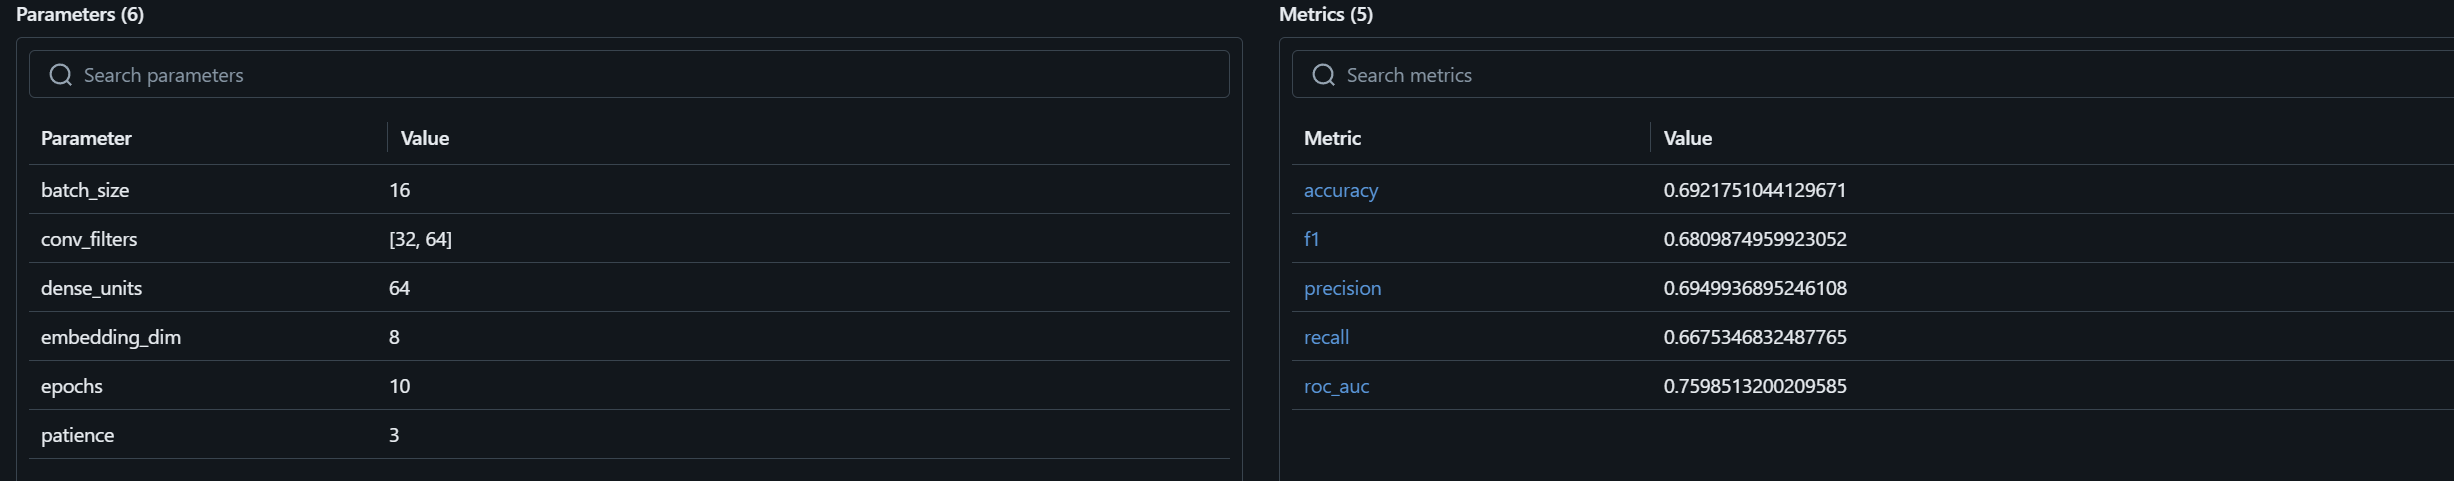

In [4]:
param_grid_clf = {
    'embedding_dim': [8],
    'conv_filters': [[32, 64]],
    'dense_units': [64],
    'epochs': [80],
    'batch_size': [16],
    'patience': [10]
}

best_clf_model = run_gridsearch_with_mlflow(
    df=df,
    target_col='eco',
    param_grid=param_grid_clf,
    task_type='classification',
    experiment_name='grid_conv_classification',
    save_dir='checkpoints/',
    return_best_model=True
)


 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 0.585295). Saving model...
 Época 1/80 | Train Loss: 0.6032 | Tiempo: 308.35s | Val Loss: 0.5853


EarlyStopping counter: 1 out of 10
 Época 2/80 | Train Loss: 0.5943 | Tiempo: 391.09s | Val Loss: 0.5887


Validation loss decreased (0.585295 --> 0.584310). Saving model...
 Época 3/80 | Train Loss: 0.5921 | Tiempo: 362.57s | Val Loss: 0.5843


Validation loss decreased (0.584310 --> 0.580703). Saving model...
 Época 4/80 | Train Loss: 0.5912 | Tiempo: 302.36s | Val Loss: 0.5807


EarlyStopping counter: 1 out of 10
 Época 5/80 | Train Loss: 0.5902 | Tiempo: 297.79s | Val Loss: 0.5863


EarlyStopping counter: 2 out of 10
 Época 6/80 | Train Loss: 0.5897 | Tiempo: 295.42s | Val Loss: 0.5886


Validation loss decreased (0.580703 --> 0.579391). Saving model...
 Época 7/80 | Train Loss: 0.5891 | Tiempo: 294.04s | Val Loss: 0.5794


EarlyStopping counter: 1 out of 10
 Época 8/80 | Train Loss: 0.5887 | Tiempo: 293.41s | Val Loss: 0.5896


EarlyStopping counter: 2 out of 10
 Época 9/80 | Train Loss: 0.5880 | Tiempo: 290.98s | Val Loss: 0.5911


EarlyStopping counter: 3 out of 10
 Época 10/80 | Train Loss: 0.5878 | Tiempo: 292.78s | Val Loss: 0.5911


EarlyStopping counter: 4 out of 10
 Época 11/80 | Train Loss: 0.5877 | Tiempo: 292.33s | Val Loss: 0.5910


EarlyStopping counter: 5 out of 10
 Época 12/80 | Train Loss: 0.5873 | Tiempo: 293.06s | Val Loss: 0.5873


EarlyStopping counter: 6 out of 10
 Época 13/80 | Train Loss: 0.5874 | Tiempo: 292.16s | Val Loss: 0.5832


EarlyStopping counter: 7 out of 10
 Época 14/80 | Train Loss: 0.5872 | Tiempo: 292.68s | Val Loss: 0.5843


EarlyStopping counter: 8 out of 10
 Época 15/80 | Train Loss: 0.5871 | Tiempo: 293.39s | Val Loss: 0.5859


EarlyStopping counter: 9 out of 10
 Época 16/80 | Train Loss: 0.5866 | Tiempo: 293.91s | Val Loss: 0.5820


EarlyStopping counter: 10 out of 10
 Época 17/80 | Train Loss: 0.5866 | Tiempo: 292.43s | Val Loss: 0.5815
Early stopping en época 17


2025/05/22 15:41:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 15:41:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 15:41:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run merciful-shrew-227 at: http://localhost:5000/#/experiments/956201576569699187/runs/ba73baaf1d814f2cb98e84a7a3429e17
🧪 View experiment at: http://localhost:5000/#/experiments/956201576569699187

 Mejor modelo guardado en: checkpoints/model_classification_20250522_154100.pt


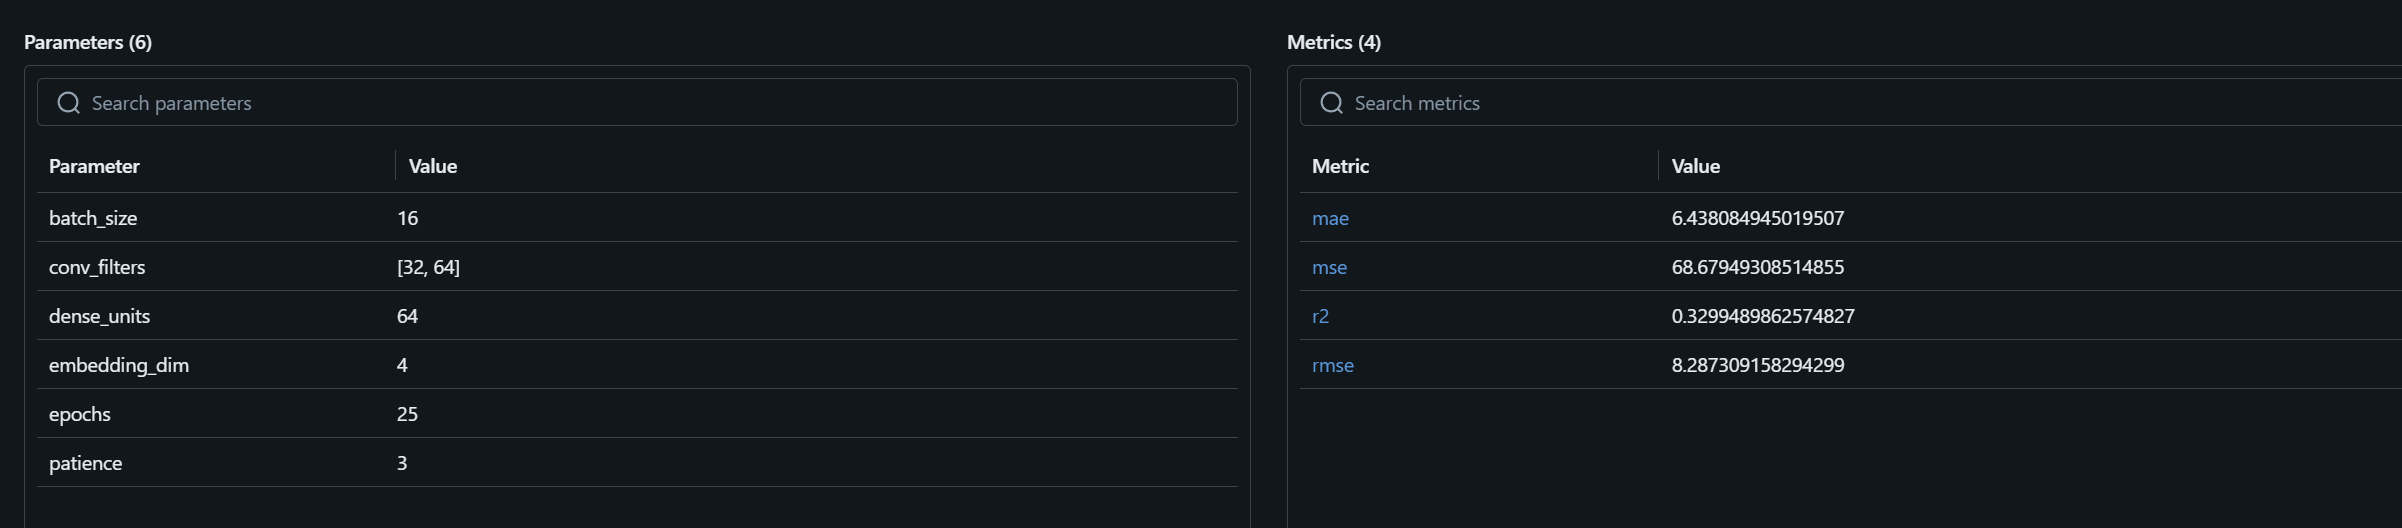

In [5]:
param_grid_reg = {
    'embedding_dim': [4],
    'conv_filters': [[32, 64]],
    'dense_units': [64],
    'epochs': [80],
    'batch_size': [16],
    'patience': [10]
}

best_reg_model = run_gridsearch_with_mlflow(
    df=df,
    target_col='punt_matematicas',
    param_grid=param_grid_reg,
    task_type='regression',
    experiment_name='grid_conv_regression',
    save_dir='checkpoints/',
    return_best_model=True
)


 Iniciando entrenamiento en cuda con 407273 muestras, 27 características (16 categóricas, 11 numéricas)


Validation loss decreased (inf --> 71.957024). Saving model...
 Época 1/80 | Train Loss: 129.5468 | Tiempo: 284.86s | Val Loss: 71.9570


Validation loss decreased (71.957024 --> 71.788048). Saving model...
 Época 2/80 | Train Loss: 91.9003 | Tiempo: 284.15s | Val Loss: 71.7880


Validation loss decreased (71.788048 --> 70.384613). Saving model...
 Época 3/80 | Train Loss: 85.5361 | Tiempo: 288.87s | Val Loss: 70.3846


Validation loss decreased (70.384613 --> 69.842728). Saving model...
 Época 4/80 | Train Loss: 81.9567 | Tiempo: 288.09s | Val Loss: 69.8427


Validation loss decreased (69.842728 --> 69.584526). Saving model...
 Época 5/80 | Train Loss: 78.9846 | Tiempo: 289.12s | Val Loss: 69.5845


Validation loss decreased (69.584526 --> 68.887108). Saving model...
 Época 6/80 | Train Loss: 76.9480 | Tiempo: 289.16s | Val Loss: 68.8871


EarlyStopping counter: 1 out of 10
 Época 7/80 | Train Loss: 75.2986 | Tiempo: 288.71s | Val Loss: 69.7446


EarlyStopping counter: 2 out of 10
 Época 8/80 | Train Loss: 73.9992 | Tiempo: 288.78s | Val Loss: 69.1659


Validation loss decreased (68.887108 --> 68.763618). Saving model...
 Época 9/80 | Train Loss: 72.9714 | Tiempo: 288.38s | Val Loss: 68.7636


EarlyStopping counter: 1 out of 10
 Época 10/80 | Train Loss: 72.2344 | Tiempo: 287.66s | Val Loss: 68.9280


Validation loss decreased (68.763618 --> 68.508774). Saving model...
 Época 11/80 | Train Loss: 71.4762 | Tiempo: 291.77s | Val Loss: 68.5088


EarlyStopping counter: 1 out of 10
 Época 12/80 | Train Loss: 71.0480 | Tiempo: 288.22s | Val Loss: 68.8020


Validation loss decreased (68.508774 --> 68.472939). Saving model...
 Época 13/80 | Train Loss: 70.6693 | Tiempo: 290.44s | Val Loss: 68.4729


EarlyStopping counter: 1 out of 10
 Época 14/80 | Train Loss: 70.3127 | Tiempo: 288.91s | Val Loss: 68.6175


EarlyStopping counter: 2 out of 10
 Época 15/80 | Train Loss: 70.1014 | Tiempo: 286.72s | Val Loss: 68.7477


EarlyStopping counter: 3 out of 10
 Época 16/80 | Train Loss: 69.9428 | Tiempo: 287.10s | Val Loss: 69.2903


Validation loss decreased (68.472939 --> 68.358971). Saving model...
 Época 17/80 | Train Loss: 69.8486 | Tiempo: 288.90s | Val Loss: 68.3590


EarlyStopping counter: 1 out of 10
 Época 18/80 | Train Loss: 69.7660 | Tiempo: 287.81s | Val Loss: 68.3989


Validation loss decreased (68.358971 --> 68.342636). Saving model...
 Época 19/80 | Train Loss: 69.7367 | Tiempo: 300.22s | Val Loss: 68.3426


EarlyStopping counter: 1 out of 10
 Época 20/80 | Train Loss: 69.6893 | Tiempo: 300.80s | Val Loss: 68.9859


EarlyStopping counter: 2 out of 10
 Época 21/80 | Train Loss: 69.6623 | Tiempo: 298.80s | Val Loss: 68.5223


EarlyStopping counter: 3 out of 10
 Época 22/80 | Train Loss: 69.6446 | Tiempo: 299.95s | Val Loss: 68.6673


EarlyStopping counter: 4 out of 10
 Época 23/80 | Train Loss: 69.6248 | Tiempo: 298.75s | Val Loss: 68.8756


EarlyStopping counter: 5 out of 10
 Época 24/80 | Train Loss: 69.5873 | Tiempo: 298.65s | Val Loss: 68.8470


EarlyStopping counter: 6 out of 10
 Época 25/80 | Train Loss: 69.5159 | Tiempo: 298.29s | Val Loss: 68.6711


EarlyStopping counter: 7 out of 10
 Época 26/80 | Train Loss: 69.5830 | Tiempo: 298.87s | Val Loss: 68.4168


EarlyStopping counter: 8 out of 10
 Época 27/80 | Train Loss: 69.3732 | Tiempo: 298.01s | Val Loss: 68.3483


EarlyStopping counter: 9 out of 10
 Época 28/80 | Train Loss: 69.4496 | Tiempo: 296.97s | Val Loss: 68.6788


EarlyStopping counter: 10 out of 10
 Época 29/80 | Train Loss: 69.4144 | Tiempo: 297.58s | Val Loss: 68.8347
Early stopping en época 29


2025/05/22 18:03:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 18:03:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/22 18:03:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run powerful-sheep-89 at: http://localhost:5000/#/experiments/294710831823527254/runs/241eee22ca9c4f1288d7467c4cf08d03
🧪 View experiment at: http://localhost:5000/#/experiments/294710831823527254

 Mejor modelo guardado en: checkpoints/model_regression_20250522_180347.pt
